#Training a Neural Network in PyTorch#

PyTorch is a powerful, widely-used machine learning library. It has all the latest neural network layers and functions and supports GPU computation.

Most neural network research these days either happens in PyTorch or TensorFlow. Google Research develops TensorFlow while Facebook AI Research develops PyTorch. Functionally they are probably very similar, I just know a lot of people who use PyTorch and it seems like it might be somewhat easier for beginners to learn. It is important to have some experience in one of these two frameworks but if you understand the ideas and concepts you shouldn't have too much trouble moving between them.

The `torch` library provides the basic functions we need when dealing with `tensors`. `tensors` are a generalization of matrices to arbirtrary numbers of dimensions (a matrix is a 2D tensor). Types of tensors:


*   0 dimensional: Scalar
*   1 dimensional: Array
*   2 dimensional: Matrix
*   3 dimensional: Number cubey thingy
*   4 dimensional: ?????

Anywho, let's start with our opening chant to invoke the power of PyTorch to aid us. The last line is a special call to the GPU gods to smile on our endeavor.


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

##Time For Some Data##

PyTorch has some built tools for downloading and loading common datasets. We'll be playing around with MNIST in this example. It is a dataset of 28x28 grayscale handwritten digits 0-9. There are 50,000 images in the training set and 10,000 in the test set.



In [ ]:
def get_mnist_data():
  trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True,
                                        transform=transforms.ToTensor())
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True,
                                            num_workers=8)

  testset = torchvision.datasets.MNIST(root='./data', train=False, download=True,
                                      transform=transforms.ToTensor())
  testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False,
                                          num_workers=8)
  classes = range(10)
  return {'train': trainloader, 'test': testloader, 'classes': classes}

data = get_mnist_data()

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


###Understanding Our Data ###
It's worthwhile to check out how our dataloader loads the images into tensors. We can print out the size of the loaded data in the `images` tensors.



In [ ]:
# get some random training images
dataiter = iter(data['train'])
images, labels = dataiter.next()
print(images.size())

torch.Size([32, 1, 28, 28])


Our `images` tensor is 4-dimensional, (32 x 1 x 28 x 28)

PyTorch stores image data in (N x C x H x W) format. Thus the size of this tensor implies we have a mini-batch of 32 images, each have a single channel (grayscale), and each image is 28 x 28, so that makes sense!

We can use matplotlib to see what our data looks like:

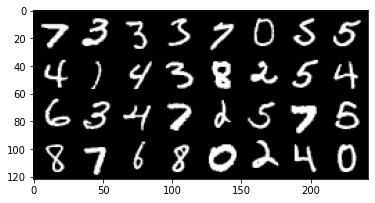

        7         3         3         3


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%9s' % data['classes'][labels[j]] for j in range(4)))


##A Simple Network##

First we'll build a very basic neural network with a single hidden layer of neurons. This means one fully connected layer of weights connects the input to the hidden neurons and one fully connected layer connects the hidden neurons to the output. We'll use the RELU activation function on the hidden neuron values as our nonlinearity.

These fully connected (or `nn.Linear`) layers expect a 2D input tensor where that is N x I where N is the number of data points in a mini batch and I is the number of inputs. However, our data is formatted in (N x C x H x W) right now so we need to tell PyTorch to rearrange it using `torch.flatten`.

After being `flatten`ed our data goes from (32 x 1 x 28 x 28) to being (32 x 784)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class SimpleNet(nn.Module):
    def __init__(self, inputs=28*28, hidden=512, outputs=10):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(inputs, hidden)
        self.fc2 = nn.Linear(hidden, outputs)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

###The Training Function ###

Now for training our network. Our `train` function takes as input the `net` to train and the `dataloader` for the training data. It also takes some optional parameters to control training.

For our network we'll be using PyTorch's built in `nn.CrossEntropyLoss`. This will apply a softmax to our network's output, calculate the log-probability assigned to each class, then try to minimize the negative log likelihood of our data (AKA maximize the likelihood)

For our optimizer we are using stochastic gradient descent with learning rate, momentum, and decay parameters.

In [ ]:
import torch.optim as optim

def train(net, dataloader, epochs=1, lr=0.01, momentum=0.9, decay=0.0, verbose=1):
  net.to(device)
  losses = []
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)
  for epoch in range(epochs):
    sum_loss = 0.0
    for i, batch in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch[0].to(device), batch[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize 
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        losses.append(loss.item())
        sum_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            if verbose:
              print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, sum_loss / 100))
            sum_loss = 0.0
  return losses

###Training The Network###

We'll instantiate a new network and train it on our training data.

Our training function prints out some debug information about the epoch, batch number, and current loss values. It also returns a list of all the losses on our mini-batches so we can plot them all once training has finished.

[1,   100] loss: 1.340
[1,   200] loss: 0.527
[1,   300] loss: 0.404
[1,   400] loss: 0.366
[1,   500] loss: 0.356
[1,   600] loss: 0.308
[1,   700] loss: 0.293
[1,   800] loss: 0.281
[1,   900] loss: 0.274
[1,  1000] loss: 0.273
[1,  1100] loss: 0.260
[1,  1200] loss: 0.242
[1,  1300] loss: 0.232
[1,  1400] loss: 0.238
[1,  1500] loss: 0.211
[1,  1600] loss: 0.224
[1,  1700] loss: 0.194
[1,  1800] loss: 0.203


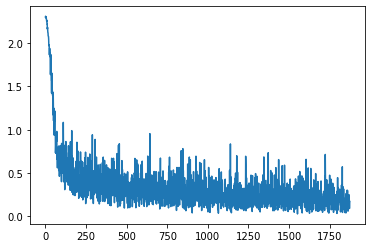

In [ ]:
net = SimpleNet()

losses = train(net, data['train'])
plt.plot(losses)

##Testing The Network##

We trained our network! The loss went down! That's good, right? But how good is our network, exactly?

Well, we can try running our network on a few of our test images and see what happens:

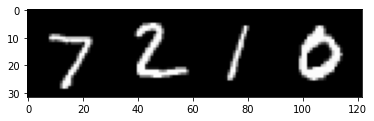

GroundTruth:      7     2     1     0
Predicted:      7     2     1     0


In [ ]:
dataiter = iter(data['test'])
images, labels = dataiter.next()
images = images[:4]
labels = labels[:4]

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % data['classes'][labels[j]] for j in range(4)))
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % data['classes'][predicted[j]]
                              for j in range(4)))

Pretty good so far. But we also want to be able to test the network on all of our data. Here's a function that can do just that, computing the accuracy on a full set of data:

In [ ]:
def accuracy(net, dataloader):
  correct = 0
  total = 0
  with torch.no_grad():
      for batch in dataloader:
          images, labels = batch[0].to(device), batch[1].to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  return correct/total

Now we can give it a try:

In [ ]:
print("Current accuracy: %f" % accuracy(net, data['train']))

Current accuracy: 0.951833


##Experiments##

Now it's time to poke around a little bit with our models. First I just want this utility function to do window smoothing of data for us. As you may have noticed, we are doing *stochastic* gradient descent, so our losses for each mini-batch can vary quite dramatically. If we smooth them out a little bit they will be easier to look at when we plot them.

In [ ]:
def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='same')

###Learning Rate###

Let's experiment around with the learning rate of our model. Changing the learning rate should affect how fast our model converges and how accurate it is. We can see the effect when we plot out the loss function over time for models with different learning rates:

0.9517 0.9479 0.8928


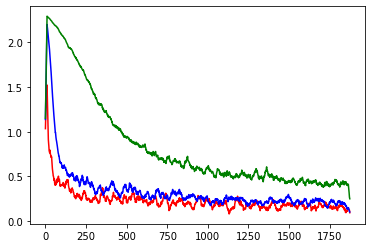

In [ ]:
net_high = SimpleNet()
losses_high = train(net_high, data['train'], lr=.1, verbose=0)
acc_high = accuracy(net_high, data['test'])
plt.plot(smooth(losses_high,20), 'r-')


net_mid = SimpleNet()
losses_mid = train(net_mid, data['train'], lr=.01, verbose=0)
acc_mid = accuracy(net_mid, data['test'])
plt.plot(smooth(losses_mid,20), 'b-')


net_low = SimpleNet()
losses_low = train(net_low, data['train'], lr=.001, verbose=0)
acc_low = accuracy(net_low, data['test'])
plt.plot(smooth(losses_low,20), 'g-')

print(acc_high, acc_mid, acc_low)

###Momentum###

We are using the default value for momentum of `0.9`. Fix your value for the learning rate and try varying the values for momentum.

####**Question 1: What affect does changing the value for momentum have on your model's convergence and final accuracy?**####

Momentum helps in faster convergence and hence higher accuracy. This is observed on increasing momentum from 0.2 to 0.8. However, on furthur increasing momentum to 0.95, it is seen that there are oscillations in the convergence, which means that the convergence rate was too high and hence the optima is missed. Hence a lower accuracy is seen at momentum=0.95.

Momentum : 0.2
0.9509
Momentum : 0.4
0.9612
Momentum : 0.6
0.9628
Momentum : 0.8
0.9659
Momentum : 0.9
0.9554
Momentum : 0.95
0.8335


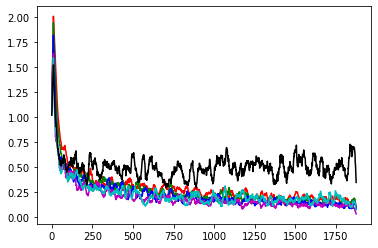

In [ ]:
#TODO: Write your code here for experimenting with different values of momentum.

print("Momentum : 0.2")
net_high = SimpleNet()
losses_high = train(net_high, data['train'], lr=.1, momentum = 0.2, verbose=0)
acc = accuracy(net_high, data['test'])
plt.plot(smooth(losses_high,20), 'r-')
print(acc)

print("Momentum : 0.4")
net_high = SimpleNet()
losses_high = train(net_high, data['train'], lr=.1, momentum = 0.4, verbose=0)
acc = accuracy(net_high, data['test'])
plt.plot(smooth(losses_high,20), 'g-')
print(acc)

print("Momentum : 0.6")
net_high = SimpleNet()
losses_high = train(net_high, data['train'], lr=.1, momentum = 0.6, verbose=0)
acc = accuracy(net_high, data['test'])
plt.plot(smooth(losses_high,20), 'b-')
print(acc)

print("Momentum : 0.8")
net_high = SimpleNet()
losses_high = train(net_high, data['train'], lr=.1, momentum = 0.8, verbose=0)
acc = accuracy(net_high, data['test'])
plt.plot(smooth(losses_high,20), 'm-')
print(acc)

print("Momentum : 0.9")
net_high = SimpleNet()
losses_high = train(net_high, data['train'], lr=.1, momentum = 0.9, verbose=0)
acc = accuracy(net_high, data['test'])
plt.plot(smooth(losses_high,20), 'c-')
print(acc)

print("Momentum : 0.95")
net_high = SimpleNet()
losses_high = train(net_high, data['train'], lr=.1, momentum = 0.95, verbose=0)
acc = accuracy(net_high, data['test'])
plt.plot(smooth(losses_high,20), 'k-')
print(acc)




###Weight Decay###

Right now we aren't using any weight decay with our model. However, it can be useful as a method of regularization if we are worried about overfitting.

Take your best performing model parameters from above for learning rate and momentum. Fix these parameters as you answer the following questions:

####**Question 2: Is our current model overfit or underfit to our training data? How can you tell?**####
Measuring the training and test accuracies, we get:
Training accuracy = 96.7%
Test accuracy = 96.15%
So the model is performing better on the training data. So the model is not underfitting. The difference between the training and test data is only a small value, so it is not overfitting as well.

####**Question 3: Try out some different values for weight decay. What effect do they have on model convergence? What about final accuracy? Does this match with what you would have expected? Why or why not?**####

Weight decay values of (0.0001,0.001, 0.01, 0.1) were tried.
As the weight decay value increases, the convergence slows down as seen in the plot. This is expected because with higher weight decay, the weights are changed by a smaller amount, so the model changes slowly and hence the convergence in slow.

Regarding the accuracy, we see that both the training and test accuracy decreases (for a fixed number of training iterations) with increasing weight decay. This is a direct consequence of the slower convergence. However another important observation regaring the accuracy is - with very small value of weight decay, the test accuracy is lower than the training accuracy, which indicates that the model has overfit to the training data. However, on increasing the weight decay, the test accuracy improves over the training accuracy which indicates that the model is no longer overfitting. On increasing  the weight decay even further, the model begins to underfit.

The observation matches with what we expected. Because the weight decay parameter ensures that model weights change by a small factor. Hence the model should converge slowly. Also, since the weights are smaller, random noise in the training data will not have much effect on the final model. The model will tend to learn only the more general patterns in the data, which will ensure that model does not overfit. Hence the observation matches with our intuition.


Concluding remarks:
Weight decay is a parameter used for making the model more generalized. Weight decay is similar or equivalent to regularization and helps in avoiding larger values for weights.
Greater the value of this lambda/ weight decay, more desensitized the model is toward the data fluctuations/ noise.
If weight decay is too high, no matter how much we train the model will never fit well and may lead to underfitting case (High bias, low variance) whereas if the weight decay is 0, there is a chance that the model will overfit and may not perform well on the unseen data. (Low Bias, High Variance)



In [ ]:
#Overfit/Underfit
print("Momentum=0.9")
print("Learning Rate=0.1")
net1 = SimpleNet()
losses1 = train(net1, data['train'], lr=0.1, momentum=0.9, decay=0.0001, verbose=0)
acc_train = accuracy(net1, data['train'])
acc_test = accuracy(net1, data['test']) 
print("Training accuracy = ", acc_train)
print("Test accuracy = ", acc_test)

Momentum=0.9
Learning Rate=0.1
Training accuracy =  0.9670333333333333
Test accuracy =  0.9615


Weight Decay : 0.0001
Training Accuracy =  0.9699666666666666
Test Accuracy =  0.9656
Weight Decay : 0.001
Training Accuracy =  0.963
Test Accuracy =  0.9594
Weight Decay : 0.01
Training Accuracy =  0.91215
Test Accuracy =  0.9168
Weight Decay : 0.1
Training Accuracy =  0.7538
Test Accuracy =  0.7607


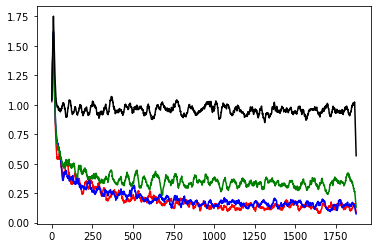

In [ ]:
#TODO: Write your code here for experimenting with different weight decay

print("Weight Decay : 0.0001")
net_high = SimpleNet()
losses_high = train(net_high, data['train'], lr=.1, momentum = 0.8, decay = 0.0001, verbose=0)
train_acc = accuracy(net_high, data['train'])
test_acc = accuracy(net_high, data['test'])
plt.plot(smooth(losses_high,20), 'r-')
print("Training Accuracy = ", train_acc)
print("Test Accuracy = ", test_acc)


print("Weight Decay : 0.001")
net_high = SimpleNet()
losses_high = train(net_high, data['train'], lr=.1, momentum = 0.8, decay = 0.001, verbose=0)
train_acc = accuracy(net_high, data['train'])
test_acc = accuracy(net_high, data['test'])
plt.plot(smooth(losses_high,20), 'b-')
print("Training Accuracy = ", train_acc)
print("Test Accuracy = ", test_acc)

print("Weight Decay : 0.01")
net_high = SimpleNet()
losses_high = train(net_high, data['train'], lr=.1, momentum = 0.8, decay = 0.01, verbose=0)
train_acc = accuracy(net_high, data['train'])
test_acc = accuracy(net_high, data['test'])
plt.plot(smooth(losses_high,20), 'g-')
print("Training Accuracy = ", train_acc)
print("Test Accuracy = ", test_acc)

print("Weight Decay : 0.1")
net_high = SimpleNet()
losses_high = train(net_high, data['train'], lr=.1, momentum = 0.8, decay = 0.1, verbose=0)
train_acc = accuracy(net_high, data['train'])
test_acc = accuracy(net_high, data['test'])
plt.plot(smooth(losses_high,20), 'k-')
print("Training Accuracy = ", train_acc)
print("Test Accuracy = ", test_acc)




###A Bigger Model###

Before we used a very simple model but now it's time to try adding some complexity. Create a network that takes as input the 28x28 image, 10 outputs, and any number of layers as long as it has fewer than 2,000,000 connections. Our simple network before had 784\*512 + 512\*10 = 406,528 connections.

Use only fully connected (`nn.Linear`) layers (we'll get to other layer types soon). However, play around with different [activation functions](https://pytorch.org/docs/stable/nn.functional.html#non-linear-activation-functions), [losses](https://pytorch.org/docs/stable/nn.html#loss-functions), and hyperparameter settings. You can also try different training regimes. For example, you could try lowering the learning rate during training by calling our training method twice like this:

    train(net, data['train'], epochs=5, lr=.1)
    train(net, data['train'], epochs=3, lr=.01)
    train(net, data['train'], epochs=2, lr=.001)

Maybe it works better? Why did I choose those particular numbers? Who knows! It's deep learning, no one really knows what will work you have to just try things and see.

Experiment with different network architectures and settings to get the most accurate model.

####**Question 4: Describe your final model architecture. How did you come up with the number of layers and number of neurons at each layer?**####

The final model architecture is follows:
  - 4 layers including the output layer
  - Linear(28\*28, 512) (28\*28\*512 = 401408 neurons)
  - Linear(512, 256) (512\*256 = 131072 neurons)
  - Linear(256, 128) (256\*128 = 32768 neurons)
  - Linear(128, 10) (128\*10 = 1280 neurons)
  -  Total 406528 connections
  - The test accuracy with this model and  (lr=.01, momentum = 0.0001, decay = 0.001, epoch=1) was 0.965

The given SimpleNet architecture had two layers. As the first step in experimentation we increased the number of layers, as we expected this to increase the levels of abstration captured by the model. For example in image recognition models, the first layers capture features like edges and higher layers capture more complex patterns. 

So we tried a model that is 3 layer deep. 
  - With this model, the accuracy was slightly lesser 0.956. Hence we went with the 4 layer architecture.
  - Then we tried the 4 layer architecture described above. 
  - We also tried a five layer architecture with first layer having 1024 o/p connections. With this the accuracy was 0.94. The larger model was taking longer to converge so the accuracy was lower. So increase in number of layers is at the cost of increased training time.

Hence we concluded on the 4 layer architecture.

Regarding the number of neurons per layer, we went with powers of 2. This is because some of the references suggested that choosing powers of 2 helps in better performance (like faster matrix multiplication) as the hardware functions like memory access and SIMD operations work in powers of 2.


####**Question 5: What hyperparameters did you experiment with? What values were good for them? Do you think your model was over or under fitting the data?**####

Below is a summary of the experiments we did:
1. Experiment changing learning rate:
    - Values tried (0.001, 0.01, 0.1, 0.2, 0.25, 0.3)
    - The best test accuracy of 0.9641 was obtained with lr=0.3

2. Experiment changing decay:
    - Values tried (0.0001, 0.001, 0.01)
    - The highest value of test accuracy (0.9659) was obtained with decay =0.0001.
    - However we noticed that this was actually overfitting the model, so we went with higer value of decay in the final experiment.

3. Experiment with changing momentum:
   - Values tried (0.0001,0.001,0.01)
   - The best test accuracy (0.9613) was obtained with momentum=0.01

4. Experiment with learning rate scheduling
   - We ran 7 epochs without lr scheduling
      test_accuracy = 0.97
      train_accuracy = 0.99
      Clearly there is overfitting on training data

    - Then we ran 7 epochs with lr scheduling 
      test_accuracy = 0.985
      train_accuracy = 0.99
      Here the test accuracy improved as compared to the case with no lr scheduling, also note that the overfitting has reduced.

5. Experiment with activation function
   - sigmoid activation was tried in all the layers.
   - A lower accuracy of 0.947 was obtained. Also, as seen from the plot of loss, the convergence is much slower with sigmoid.
   - We also tried lrelu activation in all the layers. But the RELU activation gave the better performance.


Our best model and hyperparameters (the one that gave the highest test accuracy of 0.985) was:
Model - 4 layers with RELU activaion
Hyperparameters:
  - momentum = 0.001
  - decay = 0.01
  - lr (lr scheduling: 0.3, 0.03, 0.003)
with this setting, the model was lsightly overfitting (training accuracy = 0.99, test_accuracy = 0.985)


0.251
0.8414
0.9609


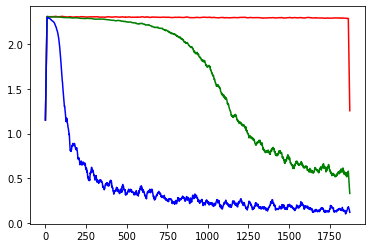

In [ ]:
#TODO: Write your new model and experiments here

class ExperiNet(nn.Module):
    #TODO: Change all this
    def __init__(self):
        super(ExperiNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)
   
        #self.lrelu = nn.LeakyReLU(0.01)

    def forward(self, x):
        x = torch.flatten(x, 1)
        
        x = self.fc1(x)
        x = F.relu (x)
        
        x = self.fc2(x)
        x = F.relu (x)

        x = self.fc3(x)
        x = F.relu (x)

        x = self.fc4(x)
        return x

#Experiment with learning rate
net_high = ExperiNet()
losses_high = train(net_high, data['train'], lr=.001, momentum = 0.0001, decay = 0.001, verbose=0)
acc = accuracy(net_high, data['test'])
plt.plot(smooth(losses_high,20), 'r-')
print(acc)


net_high = ExperiNet()
losses_high = train(net_high, data['train'], lr=.01, momentum = 0.0001, decay = 0.001, verbose=0)
acc = accuracy(net_high, data['test'])
plt.plot(smooth(losses_high,20), 'g-')
print(acc)


net_high = ExperiNet()
losses_high = train(net_high, data['train'], lr=.1, momentum = 0.0001, decay = 0.001, verbose=0)
acc = accuracy(net_high, data['test'])
plt.plot(smooth(losses_high,20), 'b-')
print(acc)



  

0.956


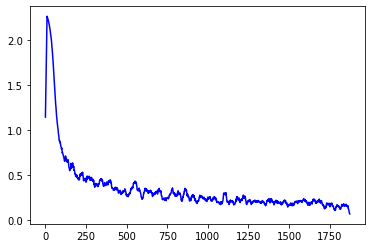

In [ ]:
class ExperiNet_three(nn.Module):
    #TODO: Change all this
    def __init__(self):
        super(ExperiNet_three, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)
   
        #self.lrelu = nn.LeakyReLU(0.01)

    def forward(self, x):
        x = torch.flatten(x, 1)
        
        x = self.fc1(x)
        x = F.relu (x)
        
        x = self.fc2(x)
        x = F.relu (x)

        x = self.fc3(x)
        return x

net_high = ExperiNet_three()
losses_high = train(net_high, data['train'], lr=.1, momentum = 0.0001, decay = 0.001, verbose=0)
acc = accuracy(net_high, data['test'])
plt.plot(smooth(losses_high,20), 'b-')
print(acc)

0.9486


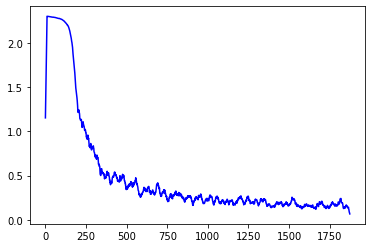

In [ ]:
class ExperiNet_five(nn.Module):
    #TODO: Change all this
    def __init__(self):
        super(ExperiNet_five, self).__init__()
        self.fc1 = nn.Linear(28*28, 1024)
        self.fc2 = nn.Linear(1024,512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 10)
   
        #self.lrelu = nn.LeakyReLU(0.01)

    def forward(self, x):
        x = torch.flatten(x, 1)
        
        x = self.fc1(x)
        x = F.relu (x)
        
        x = self.fc2(x)
        x = F.relu (x)

        x = self.fc3(x)
        x = F.relu (x)

        x = self.fc4(x)
        x = F.relu(x)

        x = self.fc5(x)
        return x


net_high = ExperiNet_five()
losses_high = train(net_high, data['train'], lr=.1, momentum = 0.0001, decay = 0.001, verbose=0)
acc = accuracy(net_high, data['test'])
plt.plot(smooth(losses_high,20), 'b-')
print(acc)

0.9609
0.9564
0.9641


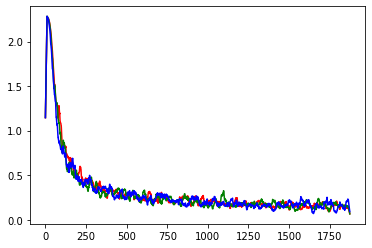

In [ ]:
#Experiment with learning rate 
net_high = ExperiNet()
losses_high = train(net_high, data['train'], lr=.2, momentum = 0.0001, decay = 0.001, verbose=0)
acc = accuracy(net_high, data['test'])
plt.plot(smooth(losses_high,20), 'r-')
print(acc)

net_high = ExperiNet()
losses_high = train(net_high, data['train'], lr=.25, momentum = 0.0001, decay = 0.001, verbose=0)
acc = accuracy(net_high, data['test'])
plt.plot(smooth(losses_high,20), 'g-')
print(acc)


net_high = ExperiNet()
losses_high = train(net_high, data['train'], lr=.3, momentum = 0.0001, decay = 0.001, verbose=0)
acc = accuracy(net_high, data['test'])
plt.plot(smooth(losses_high,20), 'b-')
print(acc)

0.9537
0.9569
0.9613


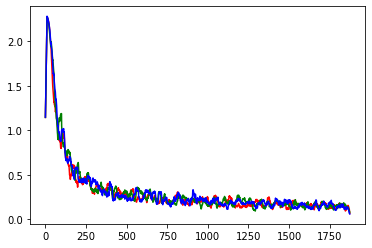

In [ ]:
#Experiment with momentum
net_high = ExperiNet()
losses_high = train(net_high, data['train'], lr=.3, momentum = 0.0001, decay = 0.001, verbose=0)
acc = accuracy(net_high, data['test'])
plt.plot(smooth(losses_high,20), 'r-')
print(acc)



net_high = ExperiNet()
losses_high = train(net_high, data['train'], lr=.3, momentum = 0.001, decay = 0.001, verbose=0)
acc = accuracy(net_high, data['test'])
plt.plot(smooth(losses_high,20), 'g-')
print(acc)



net_high = ExperiNet()
losses_high = train(net_high, data['train'], lr=.3, momentum = 0.01, decay = 0.001, verbose=0)
acc = accuracy(net_high, data['test'])
plt.plot(smooth(losses_high,20), 'b-')
print(acc)

0.9659
0.9621
0.9064


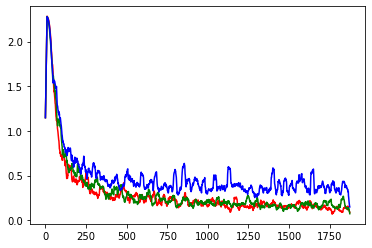

In [ ]:

#Experiment with decay
net_high = ExperiNet()
losses_high = train(net_high, data['train'], lr=.3, momentum = 0.001, decay = 0.0001, verbose=0)
acc = accuracy(net_high, data['test'])
plt.plot(smooth(losses_high,20), 'r-')
print(acc)


net_high = ExperiNet()
losses_high = train(net_high, data['train'], lr=.3, momentum = 0.001, decay = 0.001, verbose=0)
acc = accuracy(net_high, data['test'])
plt.plot(smooth(losses_high,20), 'g-')
print(acc)



net_high = ExperiNet()
losses_high = train(net_high, data['train'], lr=.3, momentum = 0.001, decay = 0.01, verbose=0)
acc = accuracy(net_high, data['test'])
plt.plot(smooth(losses_high,20), 'b-')
print(acc)


Test accuracy =  0.9768
Train accuracy =  0.9910833333333333


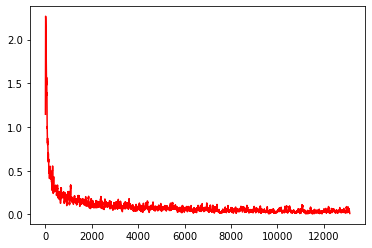

In [ ]:
#Experimenting with lr scheduling - No scheduling
net_high = ExperiNet()
losses_high = train(net_high, data['train'], lr=.3, momentum = 0.001, decay = 0.0001, verbose=0, epochs=7)
test_acc = accuracy(net_high, data['test'])
train_acc = accuracy(net_high, data['train'])
plt.plot(smooth(losses_high,20), 'r-')
print("Test accuracy = ", test_acc)
print("Train accuracy = ", train_acc)

In [ ]:
#Experimenting with lr scheduling
net_high = ExperiNet()
losses_high1 = train(net_high, data['train'], lr=.3, momentum = 0.001, decay = 0.001, verbose=0, epochs=4)
losses_high2 = train(net_high, data['train'], lr=.03, momentum = 0.001, decay = 0.001, verbose=0, epochs=2)
losses_high3 = train(net_high, data['train'], lr=.003, momentum = 0.001, decay = 0.001, verbose=0, epochs=1)
test_acc = accuracy(net_high, data['test'])
print("Test accuracy=",test_acc)
train_acc = accuracy(net_high, data['train'])
print("Train accuracy", train_acc)


Test accuracy= 0.9848
Train accuracy 0.9927333333333334


In [ ]:
#Experimenting with lr scheduling
net_high = ExperiNet()
losses_high1 = train(net_high, data['train'], lr=.1, momentum = 0.001, decay = 0.01, verbose=0, epochs=3)
losses_high2 = train(net_high, data['train'], lr=.01, momentum = 0.001, decay = 0.01, verbose=0, epochs=2)
losses_high3 = train(net_high, data['train'], lr=.001, momentum = 0.001, decay = 0.01, verbose=0, epochs=1)
test_acc = accuracy(net_high, data['test'])
print("Test accuracy=",test_acc)
train_acc = accuracy(net_high, data['train'])
print("Train accuracy", train_acc)

Test accuracy= 0.9595
Train accuracy 0.9602666666666667


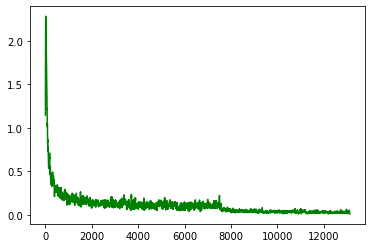

In [ ]:
losses=losses_high1 + losses_high2 + losses_high3
plt.plot(smooth(losses,20), 'g-')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0.9472


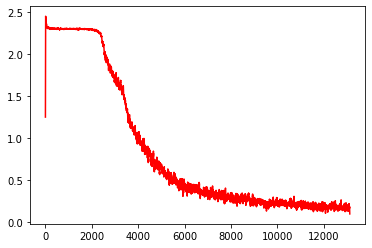

In [ ]:
#Experimenting with activation function used in the model (using sigmoid)
class ExperiNet2(nn.Module):
    #TODO: Change all this
    def __init__(self):
        super(ExperiNet2, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)
   
        #self.lrelu = nn.LeakyReLU(0.01)

    def forward(self, x):
        x = torch.flatten(x, 1)
        
        x = self.fc1(x)
        x = F.sigmoid (x)
        
        x = self.fc2(x)
        x = F.sigmoid (x)

        x = self.fc3(x)
        x = F.sigmoid (x)

        x = self.fc4(x)
        return x

#Experiment with learning rate
net_high = ExperiNet2()
losses_high = train(net_high, data['train'], lr=.3, momentum = 0.001, decay = 0.0001, verbose=0, epochs=7)
acc = accuracy(net_high, data['test'])
plt.plot(smooth(losses_high,20), 'r-')
print(acc)



In [ ]:
#Experimenting with activation function used in the model (using sigmoid)
class ExperiNet2(nn.Module):
    #TODO: Change all this
    def __init__(self):
        super(ExperiNet2, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)
   
        #self.lrelu = nn.LeakyReLU(0.01)

    def forward(self, x):
        x = torch.flatten(x, 1)
        
        x = self.fc1(x)
        x = F.sigmoid (x)
        
        x = self.fc2(x)
        x = F.sigmoid (x)

        x = self.fc3(x)
        x = F.sigmoid (x)

        x = self.fc4(x)
        return x

net_high = ExperiNet2()
losses_high = train(net_high, data['train'], lr=.3, momentum = 0.001, decay = 0.0001, verbose=0, epochs=7)
acc = accuracy(net_high, data['test'])
plt.plot(smooth(losses_high,20), 'r-')
print(acc)



Test Accuracy= 0.9816


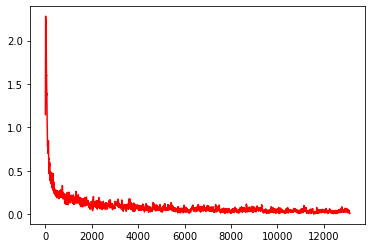

In [ ]:
#Experimenting with activation function used in the model (using LRELU)
class ExperiNet3(nn.Module):
    #TODO: Change all this
    def __init__(self):
        super(ExperiNet3, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)
   
        self.lrelu = nn.LeakyReLU(0.01)

    def forward(self, x):
        x = torch.flatten(x, 1)
        
        x = self.fc1(x)
        x = self.lrelu(x)
        
        x = self.fc2(x)
        x = self.lrelu (x)

        x = self.fc3(x)
        x = self.lrelu (x)

        x = self.fc4(x)
        return x

net_high = ExperiNet3()
losses_high = train(net_high, data['train'], lr=.3, momentum = 0.001, decay = 0.0001, verbose=0, epochs=7)
acc = accuracy(net_high, data['test'])
plt.plot(smooth(losses_high,20), 'r-')
print("Test Accuracy=", acc)



In [ ]:
#Experiment - Using LRELU with lr scheduling


In [ ]:
#Experimenting with activation function used in the model (using LRELU)
class ExperiNet4(nn.Module):
    #TODO: Change all this
    def __init__(self):
        super(ExperiNet4, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)
   
        self.lrelu = nn.LeakyReLU(0.01)

    def forward(self, x):
        x = torch.flatten(x, 1)
        
        x = self.fc1(x)
        x = self.lrelu(x)
        
        x = self.fc2(x)
        x = self.lrelu (x)

        x = self.fc3(x)
        x = self.lrelu (x)

        x = self.fc4(x)
        return x

net_high = ExperiNet4()
losses1 = train(net_high, data['train'], lr=.3, momentum = 0.001, decay = 0.0001, verbose=0, epochs=4)
losses2 = train(net_high, data['train'], lr=.03, momentum = 0.001, decay = 0.0001, verbose=0, epochs=2)
losses3 = train(net_high, data['train'], lr=.003, momentum = 0.001, decay = 0.0001, verbose=0, epochs=1)
test_acc = accuracy(net_high, data['test'])
train_acc = accuracy(net_high, data['train'])
print("Test Accuracy=", test_acc)
print("Train Accuracy=", train_acc)


Test Accuracy= 0.9828
Train Accuracy= 0.99735


##Download and submit!##

Download your iPythorn notebook from Colab to your `hw0` directory. Then follow the instructions to collate and submit your homework.